In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
seq_ori = np.load("seq_exp.npy")

In [9]:
zt_freqs = cp.linspace(-90e3, 30e3, 1000)
zt_rabi = 4.2e3
zt_pulse = 500e-6
print(zt_rabi * zt_pulse)

2.1


In [10]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=1
)

Raman thermometry: 100%|██████████| 1000/1000 [00:09<00:00, 102.95it/s]


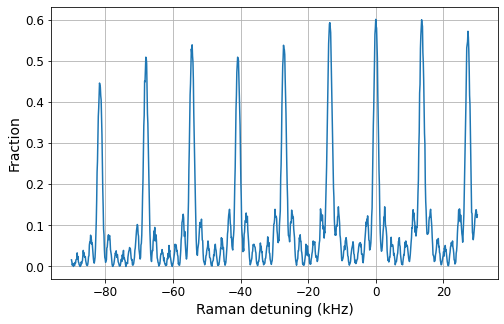

In [11]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

Raman pulses: 100%|██████████| 280/280 [00:35<00:00,  7.84it/s]


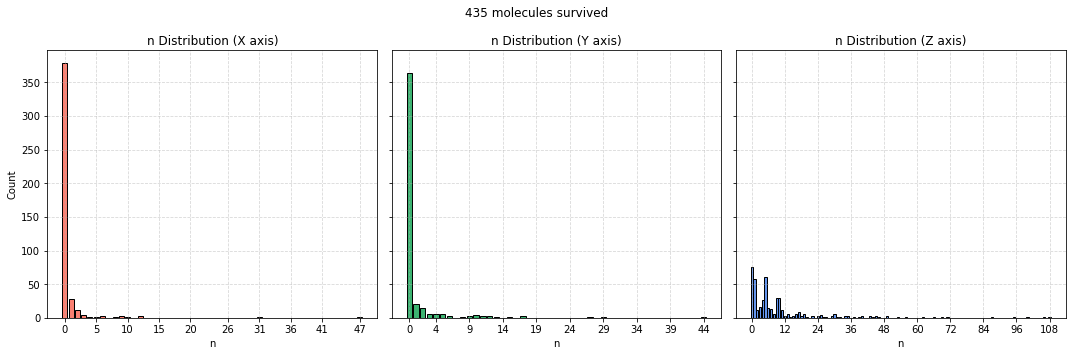

survival_rate_mean 0.435
mot_mean [0.53563218 0.95172414 9.71954023]
mot_sem [0.00457562 0.00564143 0.02298487]
Ground state rate 0.07915831663326653


In [13]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
cr.raman_cool_with_pumping(
    mol_0, 
    seq_ori, 
    res, 
    show_progress=True, 
    Detuning=(0, 0, 0),
    k_max=1,
    delta_lim=10)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=10)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])
print("Ground state rate", result['ground_state_rate_mean'])

In [14]:
frequencys, polarizations_2 = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
)

Raman thermometry: 100%|██████████| 1000/1000 [00:19<00:00, 51.57it/s]


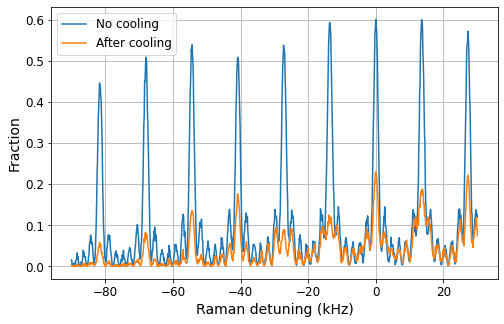

In [15]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000, label="No cooling")
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations_2)/1000, label="After cooling")
plt.legend(fontsize=12)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

### Cold sample

In [20]:
temp = [0.1e-6, 0.1e-6, 0.1e-6]
mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=3
)

Raman thermometry: 100%|██████████| 1000/1000 [00:17<00:00, 56.14it/s]


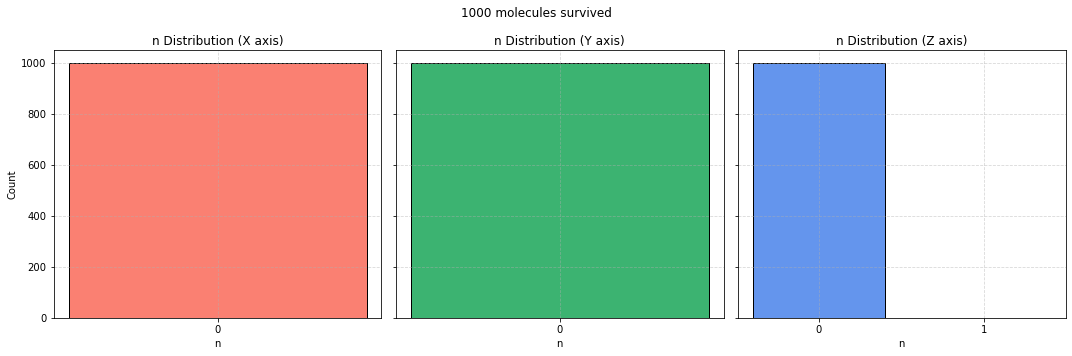

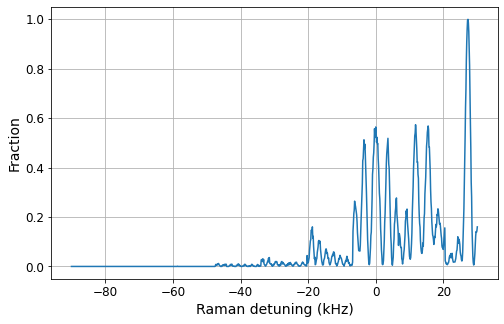

In [21]:
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=10)

plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()